# Search Query Classification

This notebook takes the *sample_data.csv* data set and classifies German search queries into 6 different classes. These are the following sections:

- Exploratory Data Analysis
- Data preprocessing
- Data Transformation
- The Deep Neural Net
- Evaluation
- Conclusion

## Exploratory Data Analysis

In this first step, the data is loaded into a Pandas dataframe. A small preprocessing step of removing 'na' values is applied to delete missing data.

There are a total of 37195 data values in the data set

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv("sample_data.csv")
df.dropna(inplace=True)
print("Total Values in data:", len(df))
df.head()

Total Values in data: 37195


,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


In this step, the counts of different classes are visualized in a bar chart to understand the data distribution. According to the chart, there is some imbalance in the data.

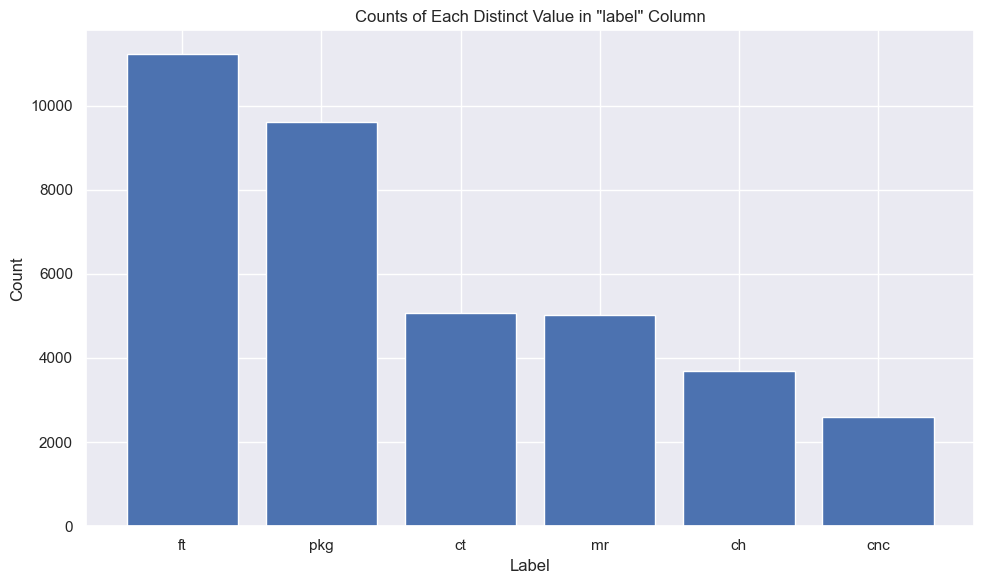

In [7]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6)) 
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Each Distinct Value in "label" Column')
plt.xticks() 
plt.tight_layout()

plt.show()

In this step, a wordcloud is created to further visualize the context of data

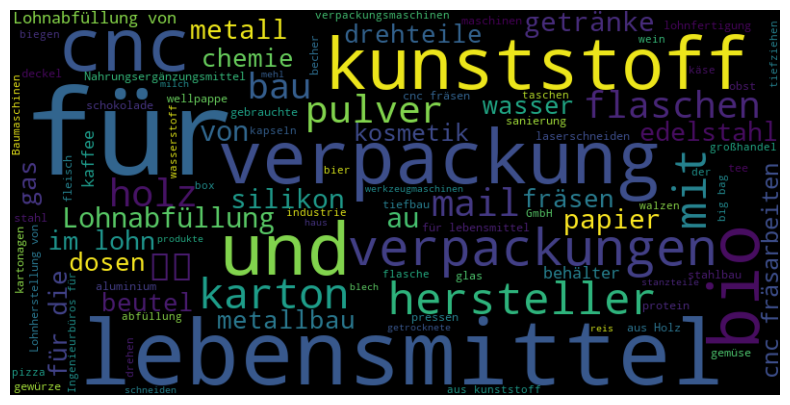

In [8]:
from wordcloud import WordCloud

text_data = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Preprocessing

The following steps are applied to preprocess the data before feeding it to the model:

- **Punctuation and Special Characters removal:** All punctuation marks and special characters are removed using a regex substitute function. These characters mostly have no information which may be important in inference. The regex removes every character which is not an alphanumeric word (\w) or a space (\s).

- **Stopwords removal:** Words such as conjuctions ("und", "aber", etc) and prepositions ("der", "die", "das", etc) are also removed for the same reason as punctuation. The NLTK library in Python provides a set of these words which has been used.

- **Stemming:** Stemming is a process to extract the stem of the word and ignore the conjugation or tense. For example, "spiele", "spielst", "spielt", all become ("spielen").

- **Tokenization:** Tokenization break texts into individual word tokens. It is a necessary step to enable word vectorizations.
    
- **Padding:** Padding is used to ensure that all text sequences have the same length. It's crucial for deep learning models that require fixed-size inputs.

- **Label Encoding (OneHotEncoding):** One-hot label encoding converts categorical labels into binary vectors, where each vector represents a single class. This encoding simplifies classification problems and helps models make predictions based on categorical inputs effectively.

In this step, stopword and punctuation removal, and stemming is applied.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

stemmer = SnowballStemmer("german")

def preprocess_text(text):

    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    stop_words = set(stopwords.words('german'))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

df['input'] = df['text'].apply(preprocess_text)

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniyaljilani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniyaljilani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label,input
0,zucker fabrik,ft,"[zuck, fabrik]"
1,Lebensmittel kommssionierung,ft,"[lebensmittel, kommssionier]"
2,geländer biegen,mr,"[geland, bieg]"
3,gebäudeausrüstung technische,ct,"[gebaudeausrust, technisch]"
4,kürbiskernöl softgels,ft,"[kurbiskernol, softgel]"


Here, the words are tokenized and padded.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['input'])
sequences = tokenizer.texts_to_sequences(df['input'])
vocab_size = len(tokenizer.word_index) + 1  

print("Vocabulary size:", vocab_size)

max_sequence_length = 100

df["input"] = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post').tolist()

df.head()

Vocabulary size: 17450


,text,label,input
0,zucker fabrik,ft,"[159, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Lebensmittel kommssionierung,ft,"[3, 6663, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,geländer biegen,mr,"[2404, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,gebäudeausrüstung technische,ct,"[567, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,kürbiskernöl softgels,ft,"[2002, 1520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In this step, the labels are encoded in a one-hot manner. Joblib helps save the binarizer so we can load it into our api and use it to inverse transform our predictions.

In [11]:
from sklearn.preprocessing import LabelBinarizer
import joblib

label_binarizer = LabelBinarizer()
one_hot_labels = label_binarizer.fit_transform(df['label'])
joblib.dump(label_binarizer, 'label_binarizer.pkl')
df['encoded_labels'] = one_hot_labels.tolist()

df.head()

,text,label,input,encoded_labels
0,zucker fabrik,ft,"[159, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 1, 0, 0]"
1,Lebensmittel kommssionierung,ft,"[3, 6663, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0]"
2,geländer biegen,mr,"[2404, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 1, 0]"
3,gebäudeausrüstung technische,ct,"[567, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 1, 0, 0, 0]"
4,kürbiskernöl softgels,ft,"[2002, 1520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0]"


## Data Transformation

The data must be transformed and split into training and testing sets to enable effective input to the model.

In this cell, the data is split into 4 sets:

- **X_train:** The text used to fit the model
- **X_test:** The text used to validate the predictions
- **y_train:** The labels used to fit the model
- **y_test:** The labels used to validate the predictions

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['input'],
    df['encoded_labels'],
    test_size=0.2,      
    random_state=10 
)

In this step, the 4 sets are converted to a numpy array, which is required by the model. Their respective sizes are also printed to guage the size of the input and validation sets.

In [13]:
import numpy as np

X_train = np.array(X_train)  
X_test = np.array(X_test)

X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = np.array([np.array(x) for x in y_train])
y_test = np.array([np.array(x) for x in y_test])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (29756, 100)
X_test shape: (7439, 100)
y_train shape: (29756, 6)
y_test shape: (7439, 6)


## The Deep Neural Net

#### Model Architecture

In this section, a deep neural network is constructed which classifies the texts into their respective categories. The model architecture is as below:

- **Sequential Model:** The Tensorflow sequential model is a straighforward model which allows to define layers in a sequentail fashion, and is appropriate for a neural network.

- **Embedding:** The Embedding layer converts tokens into dense vectors of fixed size (embedding_dim). These dense vectors capture semantic relationships between words, allowing the model to learn the meaning and context of words from data. Word embeddings are particularly useful for representing words in a way that retains their contextual information. 

- **Global Average Pooling 1D:** Global Average Pooling 1D (GAP) simplifies data by averaging features across the input sequence in a 1D neural network. Placing GAP after embedding summarizes word information while ignoring the order of words, making the model work better with different text lengths and faster to train.

- **Dense:** The dense layer in tensorflow is the layer of neurons which learn the relationships in data. The first dense layer has 32 neurons, and acts as a "hidden" layer. The second one has 6 neurons, and basically acts as an output layer, which is why it has softmax function applied on it. 

#### Hyperparameters

- **Epochs:** The number of Epochs defines how many times the model will go over the training set during training. It is set to 10 because the model is omptimized over loss within 10 epochs and further training could lead to overfitting and more processing time.

- **Batch Size:** The data is processed in batches, and then the weights are updated. For this task, the batch size is set to 32 arbitrarily, and there may be more optimal values but they are not explored as they are not necessary.

- **Adam Optimizer:** Adam is fairly easy to use because the learning rate is adaptive and does not require to be set and experimented with. Moreover, in most cases it finds the minima quite quickly and efficiently.

- **Categorical Cross Entropy Loss:** This loss function is the go-to function for multi-class classification in deep learning.

#### Saving the model for API call

The model weights are saved in a tensorflow compatible .h5 format, which will be then accessed by the API


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

embedding_dim = 100
num_classes = 6
epochs = 10
batch_size = 32


model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim, 
    input_length=max_sequence_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(32))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Model: "sequential"


2024-01-27 00:09:57.964215: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-27 00:09:57.964324: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-27 00:09:57.964341: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-27 00:09:57.964390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-27 00:09:57.964460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1745000   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1748430 (6.67 MB)
Trainable params: 1748430 (6.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-01-27 00:09:58.757745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


930/930 [==============================] - 41s 41ms/step - loss: 1.5261 - accuracy: 0.4032 - val_loss: 1.0956 - val_accuracy: 0.6288
Epoch 2/10
930/930 [==============================] - 34s 37ms/step - loss: 0.7426 - accuracy: 0.7909 - val_loss: 0.5769 - val_accuracy: 0.8391
Epoch 3/10
930/930 [==============================] - 36s 38ms/step - loss: 0.4245 - accuracy: 0.8804 - val_loss: 0.4706 - val_accuracy: 0.8528
Epoch 4/10
930/930 [==============================] - 35s 37ms/step - loss: 0.3156 - accuracy: 0.9038 - val_loss: 0.4343 - val_accuracy: 0.8606
Epoch 5/10
930/930 [==============================] - 37s 40ms/step - loss: 0.2594 - accuracy: 0.9188 - val_loss: 0.3916 - val_accuracy: 0.8754
Epoch 6/10
930/930 [==============================] - 38s 41ms/step - loss: 0.2201 - accuracy: 0.9302 - val_loss: 0.4136 - val_accuracy: 0.8704
Epoch 7/10
930/930 [==============================] - 35s 38ms/step - loss: 0.1910 - accuracy: 0.9388 - val_loss: 0.3701 - val_accuracy: 0.8821
Epo

**Save the model for the API**

In [15]:
model.save("model.h5")

/Users/daniyaljilani/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In order to evaluate the model, first Loss and Accuracy against epochs is visualized for training and testing. The model looks free from underfitting or overfitting without any additional steps required.

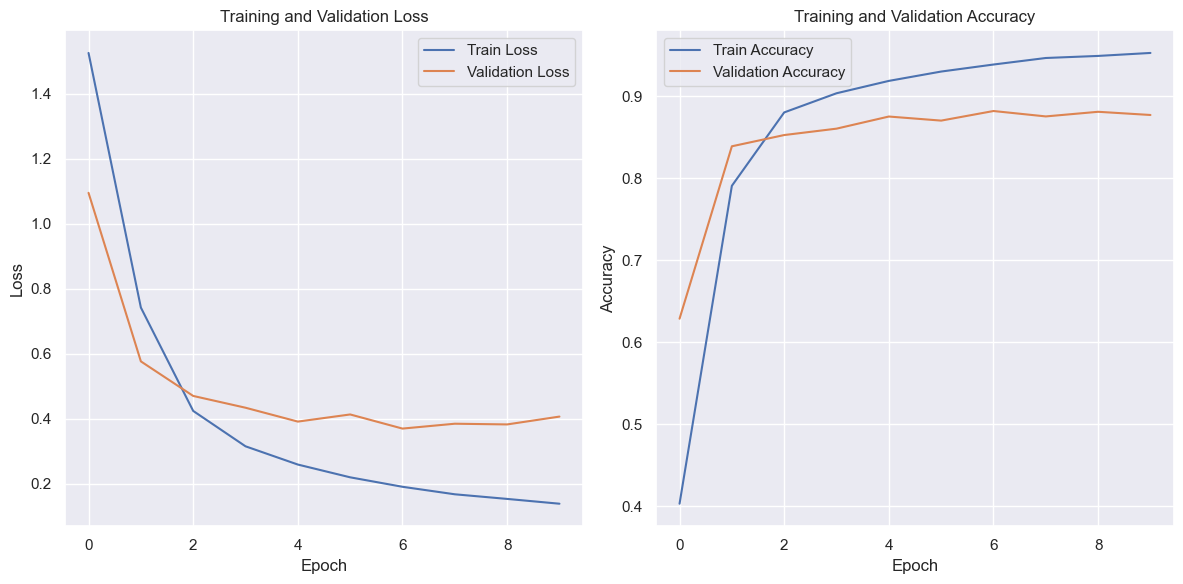

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

#### Confusion Matrix

In the next step, a confusion matrix is made to visualize the classification process. A confusion matrix is a fundamental tool for evaluating the performance of a classification model. It is a square matrix that compares the actual class labels (true values) against the predicted class labels produced by the model. The diagonal elements represent the correct predictions, where the true and predicted labels match. Off-diagonal elements represent errors: false positives and false negatives.

In [17]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=7)
    plt.yticks(tick_marks, classes, fontsize=7)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.grid(False)

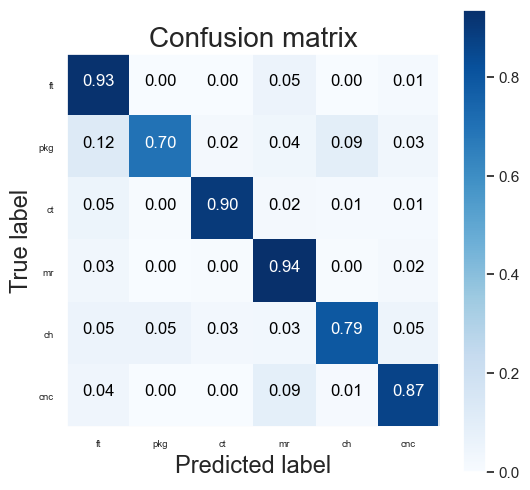

In [18]:
classes = ['ft', 'pkg', 'ct', 'mr',  'ch', 'cnc']

pred = model.predict(X_test, verbose=0, batch_size=batch_size)

pred = label_binarizer.inverse_transform(pred)
test = label_binarizer.inverse_transform(y_test)

def cnf_plotter(y_test, pred):

    cnf_matrix = confusion_matrix(y_test, pred)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=classes, title="Confusion matrix")
    plt.show()
    
cnf_plotter(test, pred)


#### Evaluation Metrics

**Accuracy:**
- Description: Measures the proportion of correctly classified instances (True Positives and True Negatives) out of the total instances in the dataset.
- Equation: $\frac{\text{True Positives} + \text{True Negatives}}{\text{True Positives} + \text{True Negatives} + \text{False Positives} + \text{False Negatives}}$

**Recall (Sensitivity/True Positive Rate):**
- Description: Quantifies the ability of the model to correctly identify all positive instances (True Positives).
- Equation: $\frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

**Precision:**
- Description: Measures the accuracy of positive predictions, indicating the proportion of true positives among all positive predictions.
- Equation: $\frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

**F1 Score:**
- Description: Combines precision and recall into a single metric, useful when there is a trade-off between these two metrics.
- Equation: $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

In [19]:

classification_report(pred, test)

'              precision    recall  f1-score   support\n\n          ch       0.93      0.69      0.79      1004\n         cnc       0.70      0.85      0.77       414\n          ct       0.90      0.95      0.92       974\n          ft       0.94      0.89      0.91      2389\n          mr       0.79      0.90      0.84       865\n         pkg       0.87      0.93      0.90      1793\n\n    accuracy                           0.88      7439\n   macro avg       0.85      0.87      0.85      7439\nweighted avg       0.88      0.88      0.88      7439\n'

#### ROC (Receiver Operating Characteristic) curve: 

It visually illustrates the trade-off between true positive rate (sensitivity) and false positive rate across multiple classes. It consists of multiple curves, one for each class, with each curve representing the performance of a class as the classification threshold varies. 

Reading an ROC curve for multi-class classification involves assessing the following key points:

1. Separation: The closer the curve is to the upper-left corner, the better the model's performance in distinguishing between classes.

2. Area Under the Curve (AUC): A higher AUC value indicates better overall performance. The micro-average AUC combines information from all classes, providing a single metric.

3. Balance: ROC curves illustrate the balance between sensitivity and specificity. A curve closer to the diagonal line suggests that the model performs poorly, as it struggles to differentiate between classes.

4. Class-Specific Performance: By examining individual class curves, you can assess how well the model discriminates between each class.

An ROC curve for multi-class classification helps evaluate the model's ability to differentiate between classes. A good model will have curves that approach the top-left corner, high AUC values, and clear separation between classes.

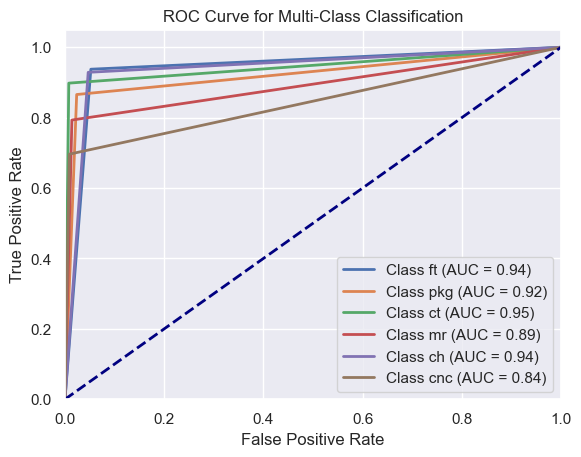

In [20]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def roc_curves(pred, test):
    # Initialize empty dictionaries to store the ROC curve data for each class
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    # Convert string labels to numeric labels for each class
    for c in classes:
        test_bin = np.array([1 if label == c else 0 for label in test])
        pred_bin = np.array([1 if label == c else 0 for label in pred])

        # Compute ROC curve for the class
        fpr, tpr, _ = roc_curve(test_bin, pred_bin)
        roc_auc = auc(fpr, tpr)

        # Store the data in the dictionaries
        fpr_dict[c] = fpr
        tpr_dict[c] = tpr
        roc_auc_dict[c] = roc_auc

    # Plot the ROC curves for each class
    plt.figure()
    lw = 2

    for c in classes:
        plt.plot(fpr_dict[c], tpr_dict[c], lw=lw, label=f'Class {c} (AUC = {roc_auc_dict[c]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

roc_curves(pred, test)

### Conclusion

This method provides a basic machine learning model capable to classify german search queries into different classes. If the data was bigger and more complex, a pretrained word embedding and a CNN or Bi-Directional LSTM architecture would have been more suitable. However, such a simple model is more than enough for classification. Some optimization methods such as grid search, l1-l2 penalization, dropout, etc were not explored as the model performed sufficiently well. Even without the hidden dense layer, model performance was good enough. 